# Pipeline from start to end for Image2Midi

### 1. Import all necessary modules

In [1]:
from collections import namedtuple
import copy as ccopy
import os
import sys

import numpy as np
import tensorflow as tf

from magenta.models.music_vae import TrainedModel
from magenta.models.music_vae import configs
from magenta import music

import joblib
from PIL import Image

np.random.seed(0)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### 2. Load tf-lite model as usual keras models

In [2]:
class WrapperTFLite:
    '''Class implementing a wrapper for tf-lite models so it can be used with 
    usual keras.Model's methods.

    Attributes:
        interpreter (tensorflow.lite.Interpreter obj): interpreter for the model.
        input_details (dict): properties about an input image, including it's shape and dtype.
        output_details (dict): properties about an output, including it's shape and dtype.
        
    '''
    __slots__ = ['interpreter', 'input_details', 'output_details']
    def __init__(self, path):
        '''Constructor of tf-lite wrapper class. In constructor you have to define a path
        to the tf lite model

            Args:
                path (str): path to a tensorflow lite model.

        '''
        self.interpreter = tf.lite.Interpreter(path)
        self.interpreter.allocate_tensors()
        # obtaining the input-output shapes and types
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def predict(self, data):
        '''Convinient method to use trained model over all data 
        (tensorflow lite models can predict only one image per time).

            Args:
                data (numpy.ndarray): array as input for the model.

            Returns:
                predictions (numpy.ndarray): model's output array.

        '''
        prediction = []
        # use tqdm for progress bar
        for i in range(data.shape[0]):
            # resize input image so it corresponds to the input shape
            img = np.array(Image.fromarray(data[i]).resize(self.input_details[0]['shape'][1:-1], Image.BICUBIC))
            self.interpreter.set_tensor(self.input_details[0]['index'], img.reshape(1, *img.shape)[:,:,:,::-1])
            # running inference
            self.interpreter.invoke()
            # get result and append to prediction list
            prediction.extend(self.interpreter.get_tensor(self.output_details[0]['index']))
        return np.array(prediction)

# load trained tf lite model
network_tflite = WrapperTFLite('colors_mobilenet.tflite')

### 3. Load musicVAE model

In [3]:
Args = namedtuple('Args', ' '.join(['batch_size', 'beta', 'data_path', 'epochs', 'exp_path',
                                    'export_step', 'init_epoch', 'init_vis_epoch',
                                    'musicvae_config', 'musicvae_path', 'task']))
args = Args(1024 * 3, 1.0, '', 200, '../exp/mnist_syn_small', 5, 101, 0,
            'cat-mel_2bar_big', '../models/cat-mel_2bar_big.ckpt', 'mnist')

sys.path.append("./")
##########     Initialization   ########
with tf.device('/gpu:0'):
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
    with tf.compat.v1.Session(config=config) as sess:
        net = TrainedModel(
            config=ccopy.deepcopy(ccopy.deepcopy(configs.CONFIG_MAP[args.musicvae_config])),
            batch_size=args.batch_size,
            checkpoint_dir_or_path=args.musicvae_path)



INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 3072, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False}

INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]


Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use keras.layers.Dense instead.
Instru

### 4. Define embeddings center clusters

In [4]:
clusters = [cluster.mean(axis=0) for cluster in joblib.load("embed.gz")]
color = ["black", "blue", "green", "grey", "orange", "purple", "red", "white", "yellow"]
for i, cluster in enumerate(clusters):
    print(color[i], cluster)

black [ 0.13708812 -0.25628036 -0.03549532  0.31956847  0.25054769 -0.43554231
 -0.07915982 -0.72031518 -0.04400819]
blue [ 0.41636727 -0.44927439  0.1734663   0.1293266  -0.50094518  0.02114657
 -0.03176783 -0.44402799  0.28354683]
green [-0.2437847  -0.44592469  0.22885615  0.70248853 -0.12507642  0.28127119
  0.19020899  0.04150721  0.2015764 ]
grey [ 0.48354217 -0.25749983  0.20004847  0.51602418 -0.04620761 -0.29798859
  0.09925249 -0.47640641  0.10601573]
orange [ 0.04593691  0.21202949  0.06637516  0.34766234  0.30468157  0.06773892
 -0.01104144 -0.81365534 -0.08368759]
purple [ 0.08178884  0.29706324 -0.0124259   0.5189675  -0.52587114 -0.30481781
 -0.12331348 -0.32207717 -0.32446807]
red [ 0.07709255  0.17995854 -0.14509952  0.55190561  0.20090736  0.36339223
 -0.1045307  -0.50895308 -0.40295803]
white [ 0.6121843  -0.03808442  0.2172002   0.58969564 -0.04374496 -0.14786779
  0.22761592 -0.26653425  0.09595956]
yellow [ 0.19398918  0.18506303  0.43629375  0.54948712 -0.0951600

### 5. Load transition matrix

In [5]:
def tanh(x):
    '''Apply tanh nonlinearity to input array.

            Args:
                x (numpy.ndarray): array.

            Returns:
                t (numpy.ndarray): array after applying tanh activation.

    '''
    exp = np.exp(x)
    exp_ = np.exp(-x)
    t = (exp - exp_)/(exp + exp_)
    return t

random_gaussians = joblib.load("gaussians200.dat")
weights_of_transition = joblib.load("best_weights_pen5.gz")
len(random_gaussians), len(weights_of_transition)

(200, 200)

### 6. Image2Vec

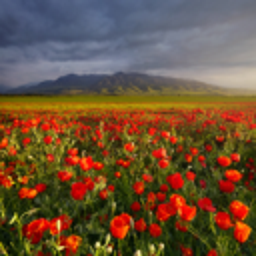

In [6]:
image = np.uint8(Image.open("test0.jpg") \
                      .resize(network_tflite.input_details[0]['shape'][1:-1], 
                              Image.BICUBIC))[:, :, ::-1]
Image.fromarray(image[:, :, ::-1]).resize((256, 256))

In [7]:
# ENCODE to color vector
encoding = network_tflite.predict(image.reshape(*network_tflite.input_details[0]['shape']))
print(encoding)
nearest = ((np.array(clusters) - encoding)**2).sum(axis=1).argsort()
print("Nearest cluster is", color[nearest[0]])

[[ 0.25807926  0.16583322 -0.0618044   0.57158756  0.2679046   0.24816616
  -0.06058797 -0.6059745  -0.2666964 ]]
Nearest cluster is red


### 7. Vec2Midi

In [8]:
# MAP to musicvae latent space
clusters[nearest[0]]
musicvae_latent_encoding = tanh(np.sum([(a*random_gaussians[j]).dot(clusters[nearest[0]].T).T for j, a 
                                                        in enumerate(weights_of_transition)], axis=0)) * 2
musicvae_latent_encoding

array([-9.41881956e-02, -1.05878283e+00, -7.10218550e-01,  3.46013822e-01,
       -6.41934506e-01, -1.08949526e+00, -3.15459592e-01, -9.21174321e-01,
       -8.22500921e-01, -1.36856484e-01,  4.93277662e-01, -6.82075562e-04,
        4.59903361e-01, -4.41326827e-02,  4.38261881e-01,  1.91537480e-01,
       -4.82805304e-02,  9.06368690e-01,  5.01567599e-01, -4.91562020e-01,
        6.55908309e-01,  3.33510044e-01, -4.21062532e-01, -8.40263618e-02,
        2.75978168e-01,  7.09730041e-01, -2.14073175e-01, -5.29448959e-01,
        8.88396192e-01, -2.37490026e-01,  2.38117731e-01, -3.06329217e-01,
       -3.35168761e-01,  4.45661484e-01, -4.72758271e-01,  1.39651082e-01,
       -5.24575093e-01,  1.60835500e-02,  4.07977698e-01, -7.55419421e-02,
        7.82988635e-01,  8.15268541e-01,  1.10728708e-01,  5.58343649e-01,
       -3.75943377e-01, -9.65638777e-01, -3.81696294e-01,  3.63479264e-02,
        4.14351552e-01, -1.20648090e-01, -5.11318374e-01, -1.66846138e-01,
       -5.09765645e-01, -

### 8. Get midi and save to disk

In [9]:
midi_representation = net.decode(musicvae_latent_encoding.reshape(1, -1), length=16, temperature=0.001)[0]
print(midi_representation)
# saving midi to disk
music.sequence_proto_to_midi_file(midi_representation,  "test0.midi")

ticks_per_quarter: 220
tempos {
  qpm: 120.0
}
notes {
  pitch: 61
  velocity: 80
  start_time: 0.25
  end_time: 0.5
}
notes {
  pitch: 63
  velocity: 80
  start_time: 0.5
  end_time: 0.75
}
notes {
  pitch: 61
  velocity: 80
  start_time: 0.75
  end_time: 1.0
}
notes {
  pitch: 64
  velocity: 80
  start_time: 1.0
  end_time: 1.25
}
notes {
  pitch: 61
  velocity: 80
  start_time: 1.25
  end_time: 1.5
}
notes {
  pitch: 66
  velocity: 80
  start_time: 1.75
  end_time: 2.0
}
total_time: 2.0


